# Machine Learning - Practical 2 - Introduction to Pytorch and Linear Regression with Pytorch

Names: {YOUR NAMES}  
Summer Term 2024   

# IMPORTANT SUBMISSION INSTRUCTIONS

You should work on the exercises in groups of 2-3. It is on you how you collaborate, but please make sure that everyone contributes equally and also that you understand all the solutions.
You will be asked to present your group's solution in the tutorials and you should be well prepared to present any part of it.

- When you've completed the exercise, download the notebook and rename it to ```<surname1>_<surname2>_<surname3>.ipynb```.
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Machine learning 1` -> `Files` -> `Submission of Homework 1`.
- Make only one submission of the exercise per group.
- The deadline is strict.
- In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials.

Implementation
- Do not change the cells which are marked as "DO NOT CHANGE", similarly write your solution to the marked cells.

## How to work on the exercise?

Generally, for machine learning you often need access to a machine with a GPU. This is not strictly required for this homework but we recommend using [Kaggle](https://www.kaggle.com/), which offers convenient access to a GPU and has all the dependencies that we need preinstalled ([here](https://gist.github.com/anwai98/444d3ff11c1365f2c610579d5df0830b) are some initial steps to work with Kaggle Notebooks). You can load this notebook on kaggle via `File` -> `Import Noteboook` -> `Browse and  Import`. Alternatively, you can also use [Colab](https://colab.research.google.com).

# Introduction

In this task you will get to know the basic tools used by the machine learning community.
Later, we will build a linear regression model with PyTorch and perform training and prediction the linear regression problem from the previous practical. The goal of this tutorial is to understand the PyTorch framework and getting to know to use it. 

## Tutorials

Some python libraries are required to accomplish the tasks assigned in this homework. If you feel like you need to follow a tutorial before, feel free to do so:

*   [PyTorch Tutorial](https://pytorch.org/tutorials/)
*   [Seaborn Tutorial](https://seaborn.pydata.org/tutorial.html) (data visualization library on top of matplotlib)


In [115]:
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import pathlib
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import sampler

In [116]:
torch.set_default_dtype(torch.float64)

## System checks

Perform some rudimentary system checks. Do we have a CUDA-capable device? Multiple? Is CuDNN active (huge speedups for some networks)?

In [112]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(False, False, 0)

If you see now that now that there is no CUDA-capable device available, you have to activate the GPU.

Click the top-right corner menu `|<` -> `Settings` -> `Accelerator` -> Select `GPU` as Hardware accelerator.

image.png

Now check the availability again (after re-running the imports)

In [117]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count(), torch.cuda.current_device()

AssertionError: Torch not compiled with CUDA enabled

Choose your device for computation. CPU or one of your CUDA devices?

In [118]:
# DO NOT CHANGE
# use_cuda = True
use_cuda = False
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


# PyTorch: Getting to know Tensors

*feel free to skip this before 'Machine Learning with Pytorch' section if you feel confident enough*   
PyTorch is a library for machine learning on arbitrary datasets, including irregular input data such as graphs, point clouds and manifolds.

In this short tutorial we will explore some of its features to handle data in tensors.
If you want, you can look into more [detailed PyTorch tutorials](https://pytorch.org/tutorials/) online.

In [119]:
# create a numpy array
numpyarray = np.arange(10).reshape(2, 5)
# convert to pytorch tensor
a = torch.from_numpy(numpyarray)

Let us find out what the properties of this tensor 'a' are.

In [ ]:
# TODO print the tensor
print(f"Tensor: \n {a} \n")

In [ ]:
# TODO print its type
print(f"Type of tensor: {a.dtype}")

In [ ]:
# TODO print its shape
print(f"Shape of tensor: {a.shape}")

In [ ]:
# TODO print its size
print(f"Size of tensor: {a.size()}")

In [ ]:
# TODO create a new numpy array out of the tensor and print its size
new_np = a.numpy()
print(f"Size of new np: \n  {new_np}")

Let's create some new tensors.

In [ ]:
# TODO create a tensor of shape (2,5) filled with ones of type int and print it
tensor = torch.rand(2,5)
print(tensor)
tensor = torch.randint(1, 2,(2,5))
print(tensor)

In [ ]:
# TODO create a tensor of shape (3,4) filled with zeros and print it
zeors_tensor=torch.zeros(3,4)
print(zeors_tensor)

In [ ]:
# TODO transpose the tensor 'a'
transpose = torch.transpose(a, 0, 1)
print(a)
print(transpose)

Now change a value in the numpy array. Does the corresponding tensor change?

In [ ]:
# TODO change value in numpy array and inspect the tensor a
print(numpyarray)
numpyarray[1,1] = 9
print(numpyarray)
print(a)  
a[1,1]=6
print(numpyarray)
print(a) 


**TODO Your answer here** 
Yes the corr. tensor does change too.

Does it work the other way round as well?

**TODO Your answer here** 
Yes it does.

Now we want to make use of the different devices available, namely cpu and gpu.

In [ ]:
# TODO move 'a' to the gpu
print(a.device)
print("CUDA GPU:", torch.cuda.is_available())
a = a.cuda()
print(a.device)
print(a)   

a[1,1]=8

print(a)

If you change a value in the tensor 'a' now, does the corresponding value in the tensor on the GPU change as well?

**TODO Your answer here** 
Yes it does change aswell.

# Machine Learning with Pytorch

The process of training and evaluating a machine learning model begins with **data loading**.
A dataset needs to be chosen on which the model should be trained.
This data might need some preprocessing (like resizing or normalizing) of images. As Pytorch does not have in-build preprocessing for data panels we have to define our custom normalization inside a Dataset or Dataloader.
Splitting of the data in different sets is necessary. We need a set to train on, a set to validate the training progress and a set to test the model after training.

The next step is to **specify the model and its optimizer**, as well as the loss function.
An important hyperparameter is the learning rate which influences how big the changes of the parameters should be after calculating the loss.

The **model fitting** is split into training and evaluation.
In the training process the model does a forward pass which means the data is presented to the model and the model outputs a prediction.
The loss compares the prediction with the ground truth.
In the backward pass the gradient with regard to the parameter is calculated and the parameter are updated by the gradient step.
In the evaluation process the loss is computed on the entire validation set.
This is done to see how well the model operates on data for which the params were not optimized before in order to avoid overfitting.
The model fitting process is repeated for `N` epochs which is another hyperparameter that needs to be chosen carefully.

After the training we evaluate the final model on the test set.

We'll go through the individual steps in the course of this notebook using linear regression as an example.


Screenshot_2020-10-05 Slides - Files - ownCloud Enterprise Edition.png

## Data Loading and Preprocessing

### Training, Validation and Test Sets

For the correct fitting of a neural network model we need three dataset components: one for training, one for validation in the training process, and the last one for testing the results of the training on unseen data.

Note that you should not use the test set in any part of your training and model selection procedure. It should be only used for showing the final results.  

Usually, train and test datasets are already split in the provided kaggle datasets but as we work with a custom dataset, we would have to make train-test split ourselves first.

In [120]:
from sklearn.model_selection import train_test_split

In [121]:
test_size = 0.2
target_clm='critical_temp'

In [122]:
# TODO: load data - same as in the previous practical and make train_test_split from sklearn
df = pd.read_csv('superconduct_train.csv')
X=df
y = df['critical_temp']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,  test_size=test_size, shuffle=True)
train, test = X_train, X_test


### Dataset

PyTorch has 2 entities to load data. They are **Dataset** and **Dataloader**.
**Dataset** is a class, which defines your data and often applies data preprocessing transformations, like normalization. It should have at least 3 functions :
* __init__ - as any other init. Usually, you would provide path to dataset here or dataset elements.
* __len__ - should return the whole dataset size
* __getitem__ - this function returns 1 pair of data and label, also here preprocessing transformations are usually applied



For the next exercise, take a look here for an example https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

In [123]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, target_clm, mean=None, std=None, normalise=True):
        '''
        TODO: save params to self attributes,
        x is data without target column
        y is target column
        transform df to_numpy
        '''
        numpy_y=df[target_clm].to_numpy()
        numpy_x = df.drop(target_clm, axis=1).to_numpy()
        #self.target_column=target_clm
        self.x = numpy_x
        self.y = numpy_y
        self.mean = np.mean(numpy_x)
        self.std = np.std(numpy_x)
        self.normalise = normalise

    def __len__(self):
        len(df)
        

    def __getitem__(self, index):
        data = self.x[index]
        if self.normalise and self.mean is not None and self.std is not None:
            data = (data - self.mean) / self.std
        return data, self.y[index]

In [124]:
tmp_dataset = Dataset(train, target_clm, normalise=False)

In [125]:
# TODO calculate the mean and standard deviation of the train dataset
mean = tmp_dataset.mean
print('Mean:  '+ str(mean))
std = tmp_dataset.std
print('Std: ' + str(std))

Mean:  540.5507131942188
Std: 1753.9690308748075


In [126]:
# TODO define new datasets with mean, std and normalise=True
conductor_train = Dataset(train,target_clm, mean, std, normalise=True)
conductor_test = Dataset(test,target_clm, mean, std, normalise=True)

We need to **split** the train dataset in two sets, one for training and one for validation.
While the training set needs to be quite large, the validation set can be relatively small.
Take 10 % of the dataset as validation set.
Assign samples *randomly* to the training and validation set, using a fixed seed to ensure that train and test splits are same across different model runs.

In fact, the good practice is to fix a global random seed not only the generator seed for even better reproducibility with `torch.manual_seed(0)`.
Machine learning models often involve random initialization of weights, augmentations, dropout layers, and other stochastic processes. Without fixing the random seed, each run of the model may produce slightly different results, making it challenging to reproduce specific results or debug issues.

In [127]:
# TODO split the train dataset in conductor_train and conductor_val
conductor_X_train, conductor_X_val, conductor_y_train, conductor_y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
conductor_train, conductor_val = conductor_X_train, conductor_X_val

In [128]:
batch_size = 256

To load the data for model training, we need to define the **dataloaders**.
A dataloader represents a Python iterable over a dataset and draws mini batches with random samples.
**Dataloader** calls \_\_getitem__ function from the Dataset and forms the batches.


Use the batch size as specified above.
Make sure we get shuffled samples in batches.

In [129]:
# TODO create dataloader for training, validation and test
train_dataloader = torch.utils.data.DataLoader(conductor_train, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(conductor_val, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

Let's get a data point now to see what we're dealing with.

For this, you might want to check out how python's iterator protocol works. It's simple and will give you an important insight into python: https://wiki.python.org/moin/Iterator.

In [130]:
# TODO get an element of the train_dataloader
for batch in train_dataloader:
    print(batch)
    break   



KeyError: 1060

In [ ]:
# TODO print the dimensions of for elements from the previous step


x has size (\[batchsize\], 81) --> 256 elements/batches (or whatever you have defined in your data loader), 81 feature values.

y has size (\[batchsize\], 1) --> 256 elements/batches (again depends on your data loader config). There's one target value for each set of the features.

## Specify Model & Optimizer

### Specify a Model

The task is now to define a model to train on the data. In this simple example, we only need **one fully-connected layer** as defined in *torch.nn.Linear* that produces a predicted label for a specific training input row.

Before, we set some variables:
- the input and output size of the linear layer
- how long we want to train the model (number of epochs) and
- the learning rate.


In [ ]:
epochs = 1
input_dim = 81
output_dim = 1
lr = 0.001

In [ ]:
class LinearRegression(torch.nn.Module):
    """
    Linear regression model inherits the torch.nn.Module
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LinearRegression, self).__init__()
        # TODO define linear layer for the model
        self.linear = torch.nn.Linear(input_dim, output_dim)


    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        # TODO flatten the input to a suitable size for the initial layer
        x = x.reshape(-1, 81)
        # TODO run the data through the layer
        outputs = self.linear(x)
        return outputs

### Instantiate the Model

Let us instantiate the model and take a look at the inside. It is always a good idea to verify that the actual architecture is what you intended it to be. Especially, when you start to create layers dynamically it is great for inspection/verification/debugging.

In [ ]:
# TODO instantiate the model
model =

Feed the model to the GPU if available.

In [ ]:
# TODO move model to device you specified above


Put the model in training mode.

In [ ]:
# TODO put the model in train mode


### Define a Loss Function

Since we're dealing with regression problem, [MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) is the canonical choice for the loss.

In [ ]:
# TODO define the loss function
loss_function = 

## Model Fitting

### Train the Model

Everything is set for the model to train!

- In the forward pass, the prediction is made using the previously defined model on the elements of the dataloader.
- Then the loss (or error) needs to be computed by comparing the prediction to the actual label.
- In the backward pass, the model learns and updates its weights based on the current gradient.

### First, let's do all of the steps manually, without using the optimizer

**Hints:**
* define number of epochs to see the dynamic. You need to see the effect over several epochs but it should no be too long. 
* use learning rate defined above as `lr`
* when doing parameters update - do it under `with torch.no_grad():`. This would disable the gradient computation for the operations under it. And we don't need gradients for updating the weights step.
* you need to update the model parameters. See [here](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html) for more details on how to access them
* don't forget to track the learning (loss)

In [ ]:
## TODO do a simple for-loop to illustrate how the gradient update if done over batches. 
## Print loss values across epochs to compare with the PyTorch optimizers later

This was equivalent to SGD optimizer

### Now let's do it in the pytorch style using the optimizer  

The optimizer is the learning algorithm we use. In this case, we use Stochastic Gradient Descent (SGD).
Redefine the model and initialize SGD optimizer

In [ ]:
# TODO Redefine the model and initialize SGD optimizer, write a train loop as above and compare the loss values

### Make a Prediction

Now that our model is trained, we can make a new prediction by inputting an unseen data row from the test dataset.

Run this cell several times, does the model predict accurately?

Set the number of epochs to 15 during training and try again!

**TODO your answer here** -

In [ ]:
# TODO get a random element of the test dataloader


# TODO make a prediction


# print predicted label and given label


### Track and Plot the Training and Validation error

What we have seen so far is the basic principle of training a model and making a prediction. But one might be interesting to see more about the training process, for instance how the training error evolves with time.

For this step, we are going to **refine the training process** and **add some important information saving for plotting**.

Create a plot using **seaborn** that contains both the losses on training set and the losses on the validation set for each epoch.

The plot should look similar to this:


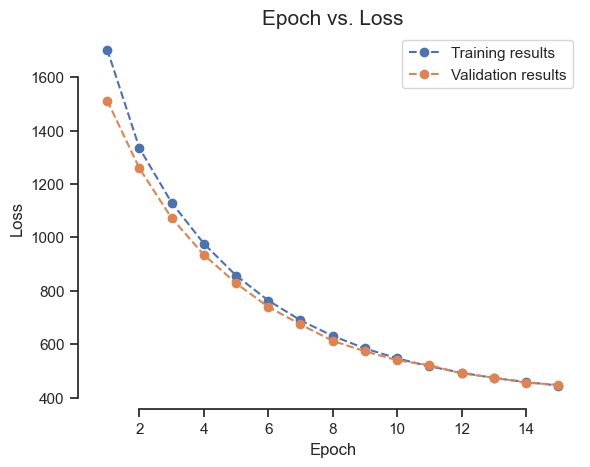


**Note:** Do not forget to add title, axis labels and a legend!
This applies in general, please keep in mind for future exercise sheets.

In [ ]:
# TODO refine the training function from above
# it should contain:
# - saving of losses
# - returning the mean loss


In [ ]:
# TODO write a validation function that calculates the loss on the validation set
# you can also combine it with the training function


In [ ]:
# TODO write a run_training function that
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses as arrays for each epoch


In [ ]:
# TODO call the run_training function and run it for 10 epochs.
num_epochs = 15


In [ ]:
# TODO write a plot function


In [ ]:
# TODO plot losses


Comment on the loss curve. Does it look as expected? Why/Why not?
If not, what might be the reason.

# Hyperparameters influence

Now, once we successfully reproduced linear regression using PyTorch, lets explore the hyperparameters influence, such as learning rate or batch size.

Train several models with 30 train epochs and using different learning rates - [0.0001, 0.001, 0.01, 0.1, 1, 10].
What do you notice? Why?

*Hints*: 
* Do not forget to reinitialize models and update the optimizers
* Use different colors and line styles to display different learning rates and train-validation splits

In [ ]:
num_epochs = 30
## TODO - train models with different learning rates

In [ ]:
## TODO plot the losses from different models. What do you see and why?

## How do we know the amount of epochs and best learning rates?

The honest answer - we just try it out. The heuristics, which are typically used are the following
* use adaptive optimizers. Adam would be a typical example. It is an adaptive learning rate optimization algorithm that is designed to be appropriate for non-stationary objectives and problems with very noisy and/or sparse gradients. More details [here](https://paperswithcode.com/method/adam). This makes the training more robust to the choise of the the learning rate
* Use schedulers for the training. They change the value of the learning rate based on the loss behaviour. The most typical ones are
  * Early stopper . The early stopper is helpful to avoid redundunt computations and overfitting. It basically stops the train loop if the loss function does not decrease on the validation split for some time.
  * Warm up. Warm up slowly increases the learning rate in the begining of the training. This helps to avoid bad influence of not-so-good initialisation and especially helpful for the layers, which need to accumulate statistics, such as BatchNorm. We will use such layers later in the course.

### Task
Modify the the training function with the early stopper logic.
This should stop the training loop if the validation loss function does not improve over $N$ epochs. The improvement is only something, which is better than the $tol$ value, which stays for the tolerance.

Use $tol=2$, $N=5$, $num\_epochs=150$, $lr=0.01$ for the function start.

**Question**:
* Can $tol=0$? Why?
* How many epochs it would really run? Try to change the $lr=0.001$ and $lr=0.0001$ and see when this would stop.
* What happens if you increase the tolerance?
* What if you increase $N$?

In [ ]:
## TODO: adopt the train function with the early stopper logic

In [ ]:
## TODO: Train models with early stopping with the different learning rates

In [ ]:
## TODO: Visualize the results. What do you see and why?

## Now lets try to explore the impact of the batch size

**Task:** Fix $num\_epochs = 150$ and $lr = 0.001$ and try to change the batch size using values $[2, 4, 32, 128, 1024]$ for the batch size.
* What impact the batch size have? Why?

In [ ]:
num_epochs = 150
lr = 0.001
## TODO: Train with different batch sizes

In [ ]:
## TODO: Visualize the differences 